In [162]:
import mne_bids
from glob import glob
import mne
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from mne.parallel import parallel_func


import mvEEG
import matplotlib.pyplot as plt
import tqdm as tqdm
import scipy.stats as sista
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ROOT = r"E:\datasets\supracapacity\derivatives\\"
DATA_DIR = ROOT + "pypeline"

EXPERIMENT_NAME='supracapacity'

dropped_chans={
    'eeg':['Fp1','Fp2'],
    'eog':'ALL',
    'eyegaze':'ALL',
    'pupil':'ALL',
    'misc':'ALL'
}

conditions = ['memory/ss2/no_placeholders','memory/ss2/placeholders',
                'memory/ss4/no_placeholders','memory/ss4/placeholders',
                'memory/ss6/no_placeholders','memory/ss6/placeholders',
                'memory/ss8/no_placeholders','memory/ss8/placeholders',
                'attention/ss2/no_placeholders','attention/ss2/placeholders',
                'attention/ss4/no_placeholders','attention/ss4/placeholders',
                'attention/ss6/no_placeholders','attention/ss6/placeholders',
                'attention/ss8/no_placeholders','attention/ss8/placeholders']

training_groups = [('memory','ss2'),('memory','ss4')]
testing_groups =  [('memory','ss2'),('memory','ss4')]

group_dict = defaultdict(None)
for igroup,group in enumerate(training_groups):
    for condition in conditions:
        if all([subgroup in condition.split('/') for subgroup in group]):
            group_dict[condition] = igroup
for igroup,group in enumerate(testing_groups):
    if group not in training_groups:
        for condition in conditions:
            if all([subgroup in condition.split('/') for subgroup in group]):
                    group_dict[condition] = 2+igroup



In [163]:
wrangl = mvEEG.Wrangler(data_dir=DATA_DIR,experiment_name=EXPERIMENT_NAME,dropped_chans=dropped_chans,conditions=conditions,training_groups=training_groups,testing_groups=testing_groups,n_folds=500)
clfr = mvEEG.Classifier()
RUN_DESCRIPTION="MEM2v4"


In [55]:
RUN_DESCRIPTION="MEM2v4"

for isub in tqdm.tqdm(range(wrangl.nsub)):
    
    try:
        Xdata,ydata = wrangl.load_eeg(isub,reject=False)
    except:
        continue

    sub_path = mne_bids.BIDSPath(root=ROOT + 'mvEEG',task=EXPERIMENT_NAME,subject=wrangl.subs[isub],description=RUN_DESCRIPTION,extension='.npy',check=False)
    sub_path.mkdir()

    parallel,p_func,_ = parallel_func(clfr.decode_across_time,n_jobs = -1)

    out = parallel(
        p_func(
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
        )
        for X_train,X_test,y_train,y_test in wrangl.bin_and_split(Xdata,ydata)
    )
    acc,acc_shuff,conf_mat,confidence_scores = map(np.stack,zip(*out))

    for suffix,array in zip(['accuracy','shuffledAccuracy','confusionMatrix','confidenceScores'],[acc,acc_shuff,conf_mat,confidence_scores]):
        sub_path.update(suffix=suffix)
        np.save(sub_path.fpath,array)
    sub_path.update(suffix='times')
    np.save(sub_path.fpath,wrangl.t)




 19%|█▉        | 6/31 [01:11<04:56, 11.88s/it]


KeyboardInterrupt: 

In [112]:
interp = mvEEG.Interpreter(data_dir = ROOT + 'mvEEG',
                     experiment_name=EXPERIMENT_NAME)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


% timepoints significant: 27.27 (15/55)%


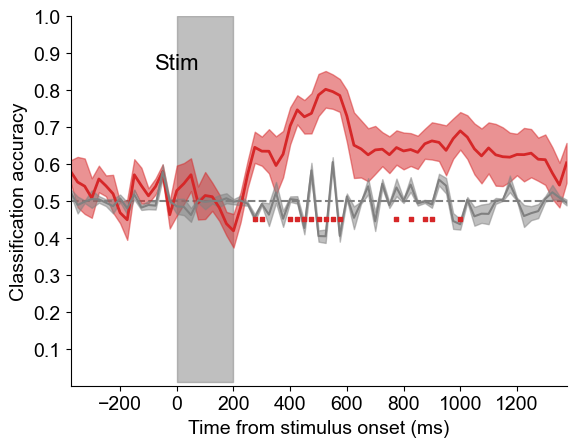

In [117]:
interp.plot_acc(significance_testing=True)

% timepoints significant for SS2 vs SS4 (alternative = two-sided): 0.0 (0/55)%


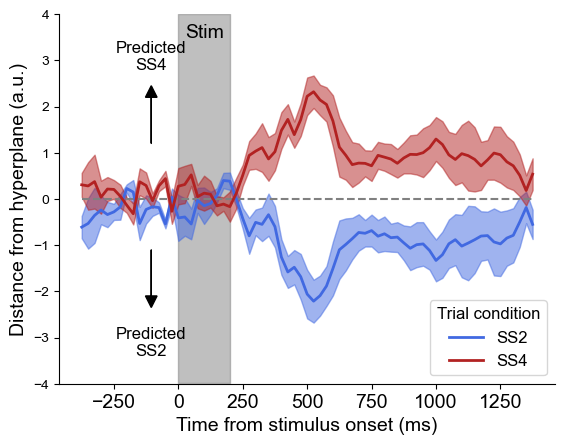

In [148]:
interp.plot_hyperplane(labels=['SS2','SS4'],significance_testing=True,alternatives=['two-sided'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


% timepoints significant: 0.0 (0/55)%


<Axes: xlabel='Time from stimulus onset (ms)', ylabel='Classification accuracy'>

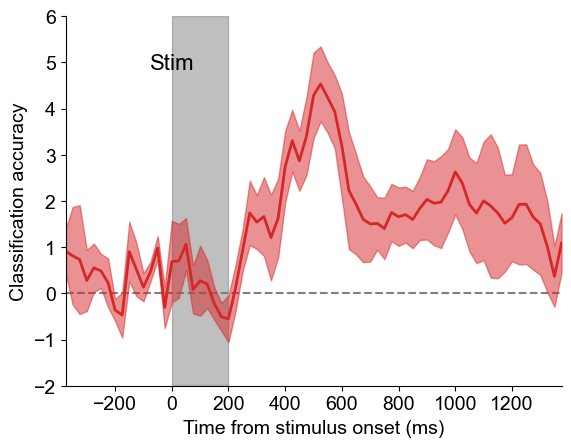

In [146]:
interp.plot_hyperplane_contrast(significance_testing=True,ylim=[-2,6])

<Axes: ylabel='True Label'>

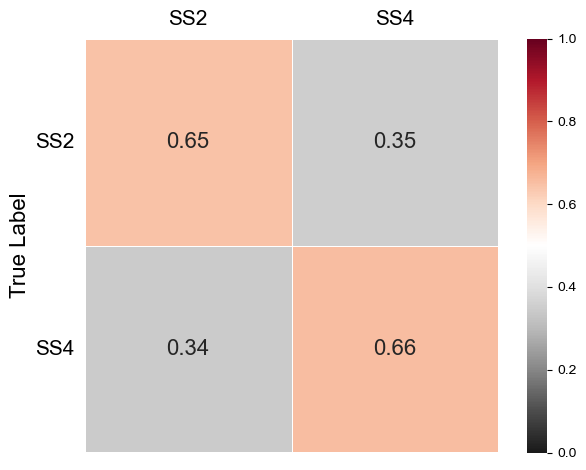

In [154]:
interp.plot_confusion_matrix(labels=['SS2','SS4'])